In [25]:
# %% Library
######################################################################################
#print("Import Libraries & Set up directory")

import urllib.request
import numpy as np
import pandas as pd
from Bio import SeqIO
import re
import os
from collections import defaultdict
from collections import Counter
import matplotlib.pyplot as plt
from statistics import mean, median, quantiles, mode

folder_path = "/Users/nguyjust/Library/CloudStorage/OneDrive-OregonHealth&ScienceUniversity/ubsite/"

### UniProt Reference File
Downloaded 5/23/2024 based on UniProt IDs from iPTM database

In [2]:
# %% Read in UniProt Reference File
######################################################################################
# Data read in
fasta_seqs = list(SeqIO.parse(
    open(folder_path + 'data/idmapping_2024_05_23_iptm.fasta'), 'fasta'))

# print("Read in fasta file")

# Clean fasta ID names for quicker query
for ii in range(len(fasta_seqs)):
    fasta_seqs[ii].id = fasta_seqs[ii].id.split("|")[1]

fasta_seq_df = pd.DataFrame(columns=['id', 'seq'])

for ii in range(len(fasta_seqs)):
    fasta_seq_df.loc[len(fasta_seq_df.index)] = [
        fasta_seqs[ii].id, fasta_seqs[ii].seq]
    # fasta_seq_df.append({'id': fasta_seqs[0].id, 'seq': fasta_seqs[0].seq}, ignore_index=True)

fasta_seq_df['seq'] = fasta_seq_df['seq'].astype(str)

fasta_seq_list = fasta_seq_df.values.tolist()

In [3]:
# EDA on raw FASTA file
print(f"number of sequences: {len(fasta_seq_df)}")

print(f"FASTA original colummns: {fasta_seq_df.columns}")

number of sequences: 23584
FASTA original colummns: Index(['id', 'seq'], dtype='object')


## iPTMnet
Main: https://research.bioinformatics.udel.edu/iptmnet/

Website: https://research.bioinformatics.udel.edu/iptmnet/download

Version: Release 6.2 (in readme.txt file)

Last Modified:

Date of Download: 05/21/2024 



In [4]:
# %% iPTM Read in
######################################################################################

## Read in the iPTM Dataset
data_iptm = pd.read_csv(folder_path + '/raw_data/iptm/ptm.txt',
                       sep="\t", low_memory=False, header=None)

'''
Columns according to readme: 	
    ptm_type 
	source 
	substrate_UniProtAC 
	substrate_genename
	organism
	site 
	enzyme_UniProtAC 
	enzyme_genename
	note 
	pmid
'''

data_iptm.rename(columns={0: 'ptm', 1: 'source', 2: 'substrate_uniprot',
                            3: 'substrate_genename', 4: 'organism', 5: 'site',
                            6: 'enzyme_uniprot', 7: 'enzyme_genename', 8: 'note', 9: 'pmid'}, inplace=True)

## Look at the columns to check file integrity
print(f"iPTM colummns: {data_iptm.columns}")

## Check by printing first row
print(data_iptm.iloc[0])

## Check Number of entries in iPTM
print(f'Number of entries in iPTM: {len(data_iptm)}')

iPTM colummns: Index(['ptm', 'source', 'substrate_uniprot', 'substrate_genename', 'organism',
       'site', 'enzyme_uniprot', 'enzyme_genename', 'note', 'pmid'],
      dtype='object')
ptm                            ACETYLATION
source                                iedb
substrate_uniprot                   A8TX70
substrate_genename                  COL6A5
organism              Homo sapiens (Human)
site                                  K652
enzyme_uniprot                         NaN
enzyme_genename                        NaN
note                          iedb:1797193
pmid                              34357683
Name: 0, dtype: object
Number of entries in iPTM: 1055800


In [5]:
## Grab relevant iptm df column 
## Data with selected data columns
data_sel_iptm = data_iptm[['ptm', 'substrate_genename', 'substrate_uniprot',
                         'organism', 'site']].copy()

## Check that correct columns is copied
data_sel_iptm.head()

,ptm,substrate_genename,substrate_uniprot,organism,site
0,ACETYLATION,COL6A5,A8TX70,Homo sapiens (Human),K652
1,ACETYLATION,MYO9A,B2RTY4,Homo sapiens (Human),K2393
2,ACETYLATION,MYO1C,O00159,Homo sapiens (Human),K396
3,ACETYLATION,ADAM10,O14672,Homo sapiens (Human),K659
4,ACETYLATION,CEP290,O15078,Homo sapiens (Human),K1350


In [6]:
## Subsect for UBIQUITINATION modification
data_sel_iptm = data_sel_iptm[data_sel_iptm['ptm'] == "UBIQUITINATION"]

## Check dataframe
print(data_sel_iptm.head())

## Check to see if grabbed only Ub modification
print(set(data_sel_iptm['ptm']))

print(len(data_sel_iptm))

                   ptm substrate_genename substrate_uniprot  \
917005  UBIQUITINATION                A2M            P01023   
917006  UBIQUITINATION               eaf1            A0ZWU1   
917007  UBIQUITINATION               eaf1            A0ZWU1   
917008  UBIQUITINATION               eaf1            A0ZWU1   
917009  UBIQUITINATION              lsd90            A9ZLL8   

                                                 organism  site  
917005                               Homo sapiens (Human)  K841  
917006  Schizosaccharomyces pombe (strain 972 / ATCC 2...  K111  
917007  Schizosaccharomyces pombe (strain 972 / ATCC 2...   K19  
917008  Schizosaccharomyces pombe (strain 972 / ATCC 2...    K6  
917009  Schizosaccharomyces pombe (strain 972 / ATCC 2...  K137  
{'UBIQUITINATION'}
138795


In [7]:
## Check organisms in dataset
print(len(set(data_sel_iptm['organism'])))

list(set(data_sel_iptm['organism']))

40


['Bos taurus OX=9913',
 'Mus musculus (Mouse)',
 'Oncorhynchus mykiss (Rainbow trout) (Salmo gairdneri)',
 'Cricetulus griseus (Chinese hamster) (Cricetulus barabensis griseus)',
 'Severe acute respiratory syndrome coronavirus 2 (2019-nCoV) (SARS-CoV-2)',
 'Drosophila melanogaster (Fruit fly)',
 'Homo sapiens (Human)',
 'Bos taurus (Bovine)',
 'rat',
 'Oryctolagus cuniculus OX=9986',
 'Gallus gallus (Chicken)',
 'Sus scrofa (Pig)',
 'Yarrowia lipolytica (strain CLIB 122 / E 150) (Yeast) (Candida lipolytica)',
 'Hepatitis C virus genotype 1a (isolate H77) OX=63746',
 'Schizosaccharomyces pombe (strain 972 / ATCC 24843) (Fission yeast)',
 'Anas platyrhynchos (Mallard) (Anas boschas)',
 'Caenorhabditis elegans',
 'Plasmodium yoelii yoelii',
 'Moloney murine leukemia virus (isolate Shinnick) (MoMLV)',
 'Tetrahymena thermophila (strain SB210)',
 'Oncorhynchus mykiss OX=8022',
 'Chlamydomonas reinhardtii (Chlamydomonas smithii)',
 'Severe acute respiratory syndrome coronavirus (SARS-CoV)',
 

In [8]:
iptm_organism_count = Counter(data_sel_iptm['organism'])
iptm_organism_count.most_common()

[('Homo sapiens (Human)', 98115),
 ('Mus musculus (Mouse)', 26169),
 ("Saccharomyces cerevisiae (strain ATCC 204508 / S288c) (Baker's yeast)",
  6947),
 ('Schizosaccharomyces pombe (strain 972 / ATCC 24843) (Fission yeast)', 5657),
 ('Rattus norvegicus (Rat)', 1674),
 ('Arabidopsis thaliana (Mouse-ear cress)', 74),
 ('mouse', 44),
 ('human', 31),
 ('Drosophila melanogaster (Fruit fly)', 15),
 ('Gallus gallus (Chicken)', 11),
 ('Strongylocentrotus purpuratus OX=7668', 6),
 ('Human spumaretrovirus (SFVcpz(hu)) (Human foamy virus)', 5),
 ('Severe acute respiratory syndrome coronavirus 2 (2019-nCoV) (SARS-CoV-2)',
  4),
 ('Sus scrofa (Pig)', 3),
 ('rat', 3),
 ('Tetrahymena thermophila (strain SB210)', 3),
 ('Bos taurus (Bovine)', 3),
 ('Anas platyrhynchos (Mallard) (Anas boschas)', 2),
 ('Zika virus (isolate ZIKV/Human/Cambodia/FSS13025/2010) OX=2316109', 2),
 ('Cricetulus griseus (Chinese hamster) (Cricetulus barabensis griseus)', 2),
 ('Gallus gallus OX=9031', 2),
 ('Tetrahymena pyriform

In [9]:
len_iptm = len(data_sel_iptm['substrate_uniprot'])
iptm_uniprot_unique = list(set(data_sel_iptm["substrate_uniprot"]))

print(f'Total iptm observations: {len_iptm}')
print(f"Total unique iptm proteins: {len(iptm_uniprot_unique)}")

Total iptm observations: 138795
Total unique iptm proteins: 23589


In [10]:
# Save UniProt IDs to file to download full information from UniProt
np.savetxt(folder_path + "data/iptm_uniprot_ids.tsv",
           iptm_uniprot_unique,
           delimiter="\t",
           fmt='% s')

In [11]:
## Find sites that do not have a lysine as the modification site
print(len(data_sel_iptm[~data_sel_iptm.site.str.match('K')]))
print(data_sel_iptm[~data_sel_iptm.site.str.match('K')])

data_sel_iptm_k = data_sel_iptm[data_sel_iptm.site.str.match('K')]

# Expect 138795 - 14 obsevations left
print(f'Observations with LYSINE: {len(data_sel_iptm_k)}')

14
                    ptm substrate_genename substrate_uniprot  \
922324   UBIQUITINATION               pub2            Q9UTG2   
939119   UBIQUITINATION              HLA-A            P04439   
941400   UBIQUITINATION             CYP3A4            P08684   
942704   UBIQUITINATION             Ifi204            P0DOV2   
978348   UBIQUITINATION               SQLE            Q14534   
981237   UBIQUITINATION             SEC23A            Q15436   
981238   UBIQUITINATION             SEC23A            Q15436   
1024911  UBIQUITINATION              RBCK1            Q9BYM8   
1024912  UBIQUITINATION              RBCK1            Q9BYM8   
1024913  UBIQUITINATION              RBCK1            Q9BYM8   
1026705  UBIQUITINATION               Mlkl            Q9D2Y4   
1026706  UBIQUITINATION               Mlkl            Q9D2Y4   
1054389  UBIQUITINATION                LTF            P02788   
1054390  UBIQUITINATION                LTF            P02788   

                                    

In [12]:
## Clean Site column to remove the K
data_sel_iptm_k = data_sel_iptm_k.reset_index()

data_sel_iptm_k['site'] = data_sel_iptm_k['site'].str[1:]

data_sel_iptm_k['site'].head()

0    841
1    111
2     19
3      6
4    137
Name: site, dtype: object

In [13]:
ids = [ii[0] for ii in fasta_seq_list]
seqs = [ii[1] for ii in fasta_seq_list]

no_ref_match = list()
# Check to see that the fragment contains a lysine
for ii in range(len(data_sel_iptm_k)):
    # print(ii)
    try:
        tmp_idx_seq = ids.index(data_sel_iptm_k['substrate_uniprot'][ii])
        temp_seq = seqs[tmp_idx_seq]
        site = temp_seq[[int(data_sel_iptm_k['ub_mod_loc'][ii])-1]]
        if site == "K":
            pass
        else:
            no_ref_match.append(ii)
    except:
        pass

In [14]:
no_ref_match

[]

In [15]:
data_sel_iptm_k.columns

data_sel_iptm_k.rename(columns = {'substrate_genename':'protein',
                                  'substrate_uniprot':'uniprot_id',
                                  'site': 'ub_mod_loc'}, inplace=True)

data_sel_iptm_k.head()

data_sel_iptm_k = data_sel_iptm_k.drop(columns=['index', 'ptm'])

data_sel_iptm_k.head()

,protein,uniprot_id,organism,ub_mod_loc
0,A2M,P01023,Homo sapiens (Human),841
1,eaf1,A0ZWU1,Schizosaccharomyces pombe (strain 972 / ATCC 2...,111
2,eaf1,A0ZWU1,Schizosaccharomyces pombe (strain 972 / ATCC 2...,19
3,eaf1,A0ZWU1,Schizosaccharomyces pombe (strain 972 / ATCC 2...,6
4,lsd90,A9ZLL8,Schizosaccharomyces pombe (strain 972 / ATCC 2...,137


In [16]:
# Write out master info
data_sel_iptm_k.to_csv(
    folder_path + '/data/iptm_info.tsv', sep='\t', index=False)

In [17]:
# Quick EDA

print(f"Number of unique sites: {len(data_sel_iptm_k['ub_mod_loc'])}")

print(f"Number of unique proteins: {len(set(data_sel_iptm_k['uniprot_id']))}")

print(f"Number of unique organisms: {len(set(data_sel_iptm_k['organism']))}")

Number of unique sites: 138781
Number of unique proteins: 23588
Number of unique organisms: 40


<BarContainer object of 23588 artists>

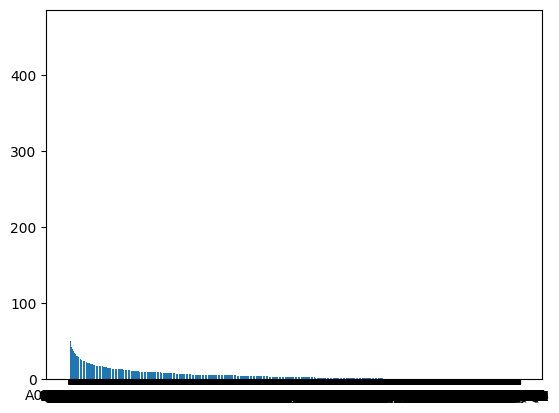

In [24]:
iptm_site_count = Counter(data_sel_iptm_k['uniprot_id'])
iptm_site_count_sort = dict(sorted(iptm_site_count.items(), key=lambda item: item[1], reverse=True))
list(iptm_site_count_sort.items())[:4]
max_y_lim = 475
plt.bar(iptm_site_count_sort.keys(),iptm_site_count_sort.values())

In [26]:

print(f'mean: {mean(iptm_site_count_sort.values())}')
print(f'median: {median(iptm_site_count_sort.values())}')
print(f'mode: {mode(iptm_site_count_sort.values())}')
print(f'quantiles: {quantiles(iptm_site_count_sort.values())}')

mean: 5.883542479226725
median: 3.0
mode: 1
quantiles: [1.0, 3.0, 7.0]
